## <font style="color:lightblue">Header</font>

### <font style="color:lightblue">Imports</font>

In [1]:
#%load_ext autoreload
#%autoreload 2

import math
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
import itertools
import random

import sinogap_module as sg




### <font style="color:lightblue">Redefine</font>

In [2]:
sg.plt.rcParams['figure.dpi']=223





### <font style="color:lightblue">Configs</font>

In [3]:
sg.set_seed(7)

sg.TCfg = sg.TCfgClass(
     exec = 1
    ,nofEpochs = None
    ,latentDim = 64
    ,batchSize = 1024    #16384 #32768
    ,labelSmoothFac = 0.1 # For Fake labels (or set to 0.0 for no smoothing).
    ,learningRateD = 0.0002
    ,learningRateG = 0.0002
)

sg.DCfg = sg.DCfgClass(8)


### <font style="color:lightblue">Raw Read</font>

In [4]:
trainSet = sg.createTrainSet()
prepGdLoss=0

testSet = sg.createTestSet()

Loaded set 4176862R_Eig_Threshold-4keV
Loaded set 18515.Lamb1_Eiger_7m_45keV_360Scan
Loaded set 23574.8965435L.Eiger.32kev_org
Loaded set 23574.8965435L.Eiger.32kev_sft


### <font style="color:lightblue">Show</font>

-4.105e-01, 3.546e-03, -4.227e-01, -3.957e-01


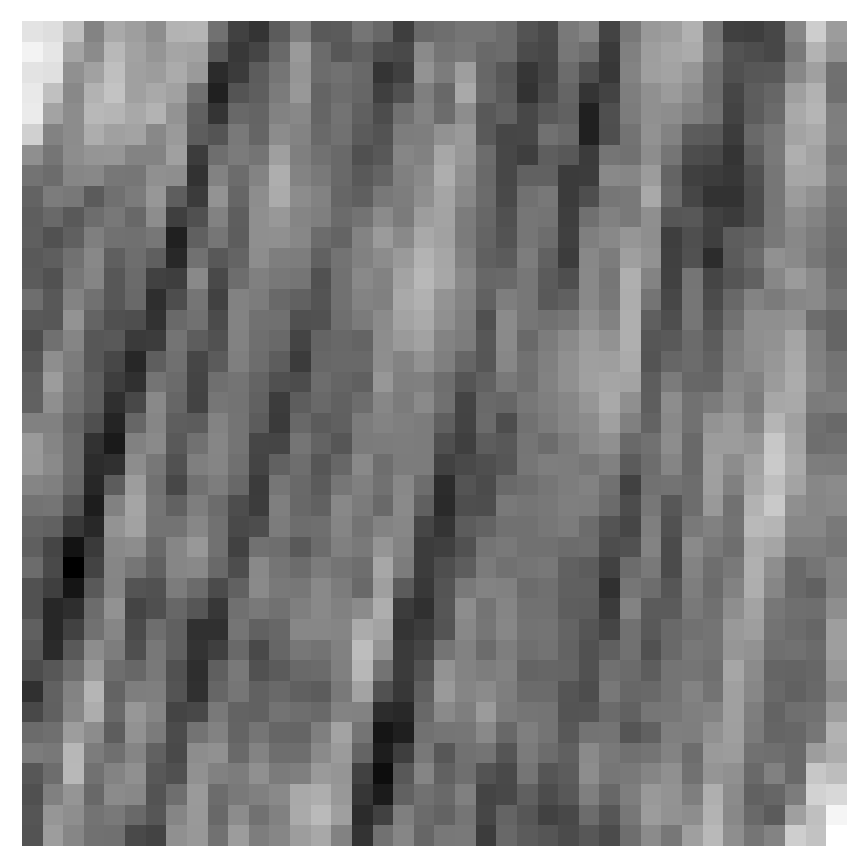

In [5]:
sg.refImages, sg.refNoises = sg.createReferences(trainSet, 0)
sg.showMe(trainSet, 0)

## <font style="color:lightblue">Models</font>

### Generator 2pix

In [6]:


class Generator2(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator2, self).__init__(2)

        #latentChannels = 7
        #self.noise2latent = nn.Sequential(
        #    nn.Linear(sg.TCfg.latentDim, self.sinoSize*latentChannels),
        #    nn.ReLU(),
        #    nn.Unflatten( 1, (latentChannels,) + self.sinoSh )
        #)

        baseChannels = 64

        self.encoders =  nn.ModuleList([
            self.encblock(  1,                baseChannels, 3, norm=False),
            self.encblock(  baseChannels,     baseChannels, 3),
            self.encblock(  baseChannels,     baseChannels, 3),
            ])
        sg.fillWheights(self.encoders)

        self.fcLink = self.createFClink()
        sg.fillWheights(self.fcLink)

        self.decoders = nn.ModuleList([
            self.decblock(2*baseChannels, baseChannels, 3),
            self.decblock(2*baseChannels, baseChannels, 3),
            self.decblock(2*baseChannels, baseChannels, 3, norm=False),
            ])

        self.lastTouch = nn.Sequential(
            nn.Conv2d(baseChannels+1, 1, 1),
            nn.Tanh(),
        )
        sg.fillWheights(self.lastTouch)


    def forward(self, input):

        images, _ = input
        images, orgDims = sg.unsqeeze4dim(images)
        modelIn = images.clone()
        modelIn[self.gapRng] = self.preProc(images)

        minv = modelIn.min(dim=-1).values.min(dim=-1).values
        ampl = modelIn.max(dim=-1).values.max(dim=-1).values - minv
        minv = minv[:,:,None,None]
        ampl = ampl[:,:,None,None]
        iampl = torch.where(ampl==0, 0, 2/ampl)
        modelIn = ( modelIn - minv ) * iampl - 1 # stretch

        #latent = self.noise2latent(noises)
        #modelIn = torch.cat((modelIn,latent),dim=1).to(sg.TCfg.device)
        dwTrain = [modelIn,]
        for encoder in self.encoders :
            dwTrain.append(encoder(dwTrain[-1]))
        mid = self.fcLink(dwTrain[-1])
        upTrain = [mid]
        for level, decoder in enumerate(self.decoders) :
            upTrain.append( decoder( torch.cat( (upTrain[-1], dwTrain[-1-level]), dim=1 ) ) )
        res = self.lastTouch(torch.cat( (upTrain[-1], modelIn), dim=1 ))

        patches = ( 2*res[self.gapRng] + modelIn[:,[0],:, self.gapRngX] + 1 ) * ampl / 2 + minv #destretch
        return sg.squeezeOrg(patches, orgDims)



generator2 = Generator2()
generator2 = sg.load_model(generator2, model_path="saves/gen2.pt" )
generator2 = generator2.to(sg.TCfg.device)
generator2 = generator2.requires_grad_(False)
generator2 = generator2.eval()
sg.lowResGenerators[2] = generator2




/home/imbl/usr/src/sinogap/sinogap_module.py:247: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=TCfg.device))


### Generator 4pix

In [7]:


class Generator4(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator4, self).__init__(4)

        #latentChannels = 7
        #self.noise2latent = nn.Sequential(
        #    nn.Linear(sg.TCfg.latentDim, self.sinoSize*latentChannels),
        #    nn.ReLU(),
        #    nn.Unflatten( 1, (latentChannels,) + self.sinoSh )
        #)

        baseChannels = 64


        self.encoders =  nn.ModuleList([
            self.encblock(  1,                  baseChannels, 3, norm=False),
            self.encblock(  baseChannels,       baseChannels, 3),
            self.encblock(  baseChannels,     2*baseChannels, 3, stride=2),
            self.encblock(  2*baseChannels,   2*baseChannels, 3),
            self.encblock(  2*baseChannels,   4*baseChannels, 3),
            ])
        sg.fillWheights(self.encoders)

        self.fcLink = self.createFClink()
        sg.fillWheights(self.fcLink)

        self.decoders = nn.ModuleList([
            self.decblock(8*baseChannels, 2*baseChannels, 3),
            self.decblock(4*baseChannels, 2*baseChannels, 3),
            self.decblock(4*baseChannels,   baseChannels, 4, stride=2),
            self.decblock(2*baseChannels,   baseChannels, 3),
            self.decblock(2*baseChannels,   baseChannels, 3, norm=False),
            ])

        self.lastTouch = nn.Sequential(
            nn.Conv2d(baseChannels+1, 1, 1),
            nn.Tanh(),
        )
        sg.fillWheights(self.lastTouch)


    def forward(self, input):

        images, noises = input
        images, orgDims = sg.unsqeeze4dim(images)
        modelIn = images.clone()
        modelIn[self.gapRng] = self.preProc(images)

        #latent = self.noise2latent(noises)
        #modelIn = torch.cat((modelIn,latent),dim=1).to(sg.TCfg.device)
        dwTrain = [modelIn,]
        for encoder in self.encoders :
            dwTrain.append(encoder(dwTrain[-1]))
        mid = self.fcLink(dwTrain[-1])
        upTrain = [mid]
        for level, decoder in enumerate(self.decoders) :
            upTrain.append( decoder( torch.cat( (upTrain[-1], dwTrain[-1-level]), dim=1 ) ) )
        res = self.lastTouch(torch.cat( (upTrain[-1], modelIn ), dim=1 ))

        patches = modelIn[self.gapRng] + 2 * res[self.gapRng]
        return sg.squeezeOrg(patches, orgDims)

generator4 = Generator4()
generator4 = sg.load_model(generator4, model_path="saves/gen4.pt" )
generator4 = generator4.to(sg.TCfg.device)
generator4 = generator4.requires_grad_(False)
generator4 = generator4.eval()
sg.lowResGenerators[4] = generator4




### <font style="color:lightblue">Generator</font>

In [8]:


class Generator8(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator8, self).__init__(8)

        #latentChannels = 7
        #self.noise2latent = nn.Sequential(
        #    nn.Linear(sg.TCfg.latentDim, self.sinoSize*latentChannels),
        #    nn.ReLU(),
        #    nn.Unflatten( 1, (latentChannels,) + self.sinoSh )
        #)

        baseChannels = 64

        self.encoders =  nn.ModuleList([
            self.encblock( 1,                  baseChannels, 3, norm=False),
            self.encblock( baseChannels,       baseChannels, 3, dopadding=True),
            self.encblock( baseChannels,     2*baseChannels, 3, stride=2),
            self.encblock( 2*baseChannels,   2*baseChannels, 3, dopadding=True),
            self.encblock( 2*baseChannels,   4*baseChannels, 3, stride=2),
            self.encblock( 4*baseChannels,   4*baseChannels, 3, dopadding=True),
            self.encblock( 4*baseChannels,   8*baseChannels, 3, stride=2),
            self.encblock( 8*baseChannels,   8*baseChannels, 3, dopadding=True),
            ])
        sg.fillWheights(self.encoders)

        self.fcLink = self.createFClink()
        sg.fillWheights(self.fcLink)

        self.decoders = nn.ModuleList([
            self.decblock(16*baseChannels, 8*baseChannels, 3, dopadding=True),
            self.decblock(16*baseChannels, 4*baseChannels, 4, stride=2),
            self.decblock( 8*baseChannels, 4*baseChannels, 3, dopadding=True),
            self.decblock( 8*baseChannels, 2*baseChannels, 4, stride=2),
            self.decblock( 4*baseChannels, 2*baseChannels, 3, dopadding=True),
            self.decblock( 4*baseChannels,   baseChannels, 4, stride=2),
            self.decblock( 2*baseChannels,   baseChannels, 3, dopadding=True),
            self.decblock( 2*baseChannels,   baseChannels, 3, norm=False),
            ])

        self.lastTouch = nn.Sequential(
            nn.Conv2d(baseChannels+1, 1, 1),
            nn.Tanh(),
        )
        sg.fillWheights(self.lastTouch)


    def forward(self, input):

        images, noises = input
        images, orgDims = sg.unsqeeze4dim(images)
        modelIn = images.clone()
        modelIn[self.gapRng] = self.preProc(images)

        #latent = self.noise2latent(noises)
        #modelIn = torch.cat((modelIn,latent),dim=1).to(sg.TCfg.device)
        dwTrain = [modelIn,]
        for encoder in self.encoders :
            dwTrain.append(encoder(dwTrain[-1]))
        mid = self.fcLink(dwTrain[-1])
        #return mid
        upTrain = [mid]
        for level, decoder in enumerate(self.decoders) :
            upTrain.append( decoder( torch.cat( (upTrain[-1], dwTrain[-1-level]), dim=1 ) ) )
        res = self.lastTouch(torch.cat( (upTrain[-1], modelIn ), dim=1 ))

        patches = modelIn[self.gapRng] + 2 * res[self.gapRng]
        return sg.squeezeOrg(patches, orgDims)

sg.generator = Generator8()
sg.generator.to(sg.TCfg.device)
model_summary = summary(sg.generator, input_data=[ [sg.refImages[[0],...], sg.refNoises[[0],...]] ] ).__str__()
print(model_summary)

sg.optimizer_G = sg.createOptimizer(sg.generator, sg.TCfg.learningRateG)


Layer (type:depth-idx)                   Output Shape              Param #
Generator8                               [1, 1, 40, 8]             --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 64, 38, 38]           --
│    │    └─Conv2d: 3-1                  [1, 64, 38, 38]           640
│    │    └─LeakyReLU: 3-2               [1, 64, 38, 38]           --
│    └─Sequential: 2-2                   [1, 64, 38, 38]           --
│    │    └─Conv2d: 3-3                  [1, 64, 38, 38]           36,928
│    │    └─BatchNorm2d: 3-4             [1, 64, 38, 38]           128
│    │    └─LeakyReLU: 3-5               [1, 64, 38, 38]           --
│    └─Sequential: 2-3                   [1, 128, 18, 18]          --
│    │    └─Conv2d: 3-6                  [1, 128, 18, 18]          73,856
│    │    └─BatchNorm2d: 3-7             [1, 128, 18, 18]          256
│    │    └─LeakyReLU: 3-8               [1, 128, 18, 18]          --
│   

### <font style="color:lightblue">Discriminator</font>

In [9]:

class Discriminator(sg.DiscriminatorTemplate):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.param = nn.Parameter(torch.zeros(1))
    def forward(self, images):
        return torch.zeros((images.shape[0],1), device=images.device)


sg.discriminator = Discriminator()
sg.discriminator = sg.discriminator.to(sg.TCfg.device)
model_summary = summary(sg.discriminator, input_data=sg.refImages[0,...] ).__str__()
#print(model_summary)
#sg.writer.add_graph(sg.discriminator, refImages)

sg.optimizer_D = sg.createOptimizer(sg.discriminator, sg.TCfg.learningRateD)



## <font style="color:lightblue">Restore checkpoint</font>

/home/imbl/usr/src/sinogap/sinogap_module.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkPoint = torch.load(path, map_location=TCfg.device)


Probabilities of reference images: Ref: 0.000e+00, Gen: 0.000e+00, Pre: 0.000e+00.
Distances of reference images: REC: 1.877e-03, MSE: 1.877e-03, L1L: 2.131e-02.


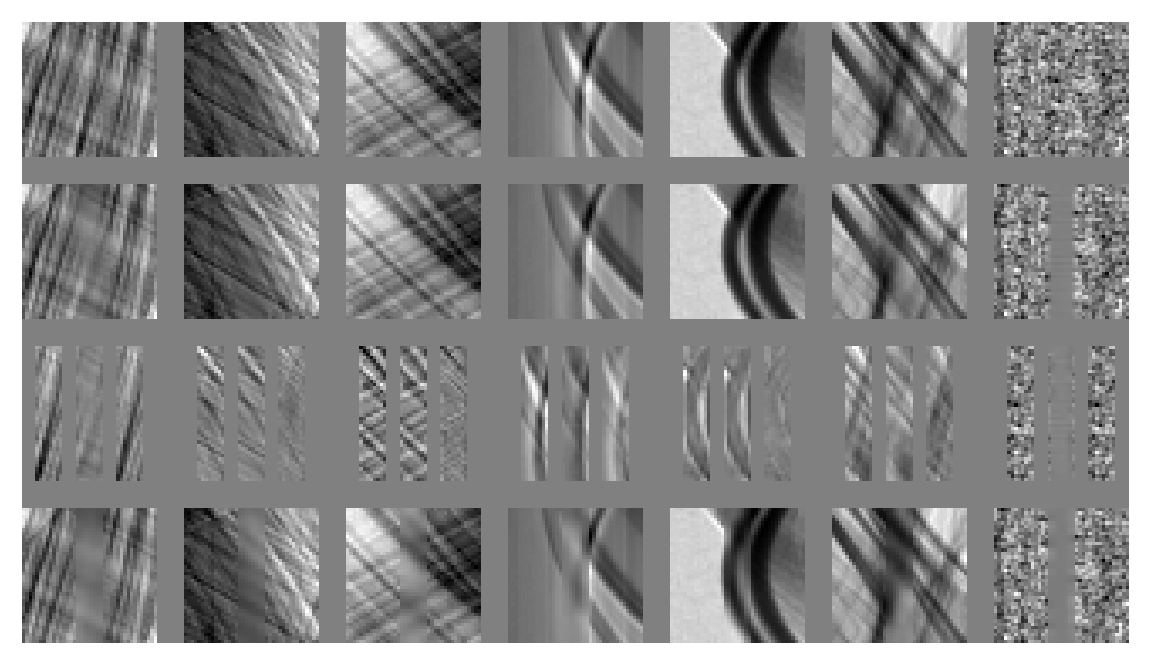

In [10]:
savedCheckPoint = f"checkPoint_{sg.TCfg.exec}"
sg.epoch, sg.iter, sg.minGEpoch, sg.minGdLoss = sg.restoreCheckpoint(savedCheckPoint+".pth")
sg.writer = sg.createWriter(sg.TCfg.logDir, True)
sg.writer.add_graph(sg.generator, ((sg.refImages, sg.refNoises),) )
#sg.writer.add_graph(sg.discriminator, refImages)
sg.initialTest()

## <font style="color:lightblue">Execute</font>

Epoch: 723 (710).  L1L: 1.134e-02  MSE: 3.362e-04  Rec: 3.591e-04 (3.585e-04 / 5.178e-04).
TT: 0.00 (1036341,528),  FT: 0.00 (5012664,278),  HD: 4.403e-03 (4983034,1609),  GP: 0.000, 0.000 
TF: 0.00 (2622385,1600),  FF: 0.00 (4606729,2825),  LD: 2.479e-07 (1521613,0),  R : 0.000.


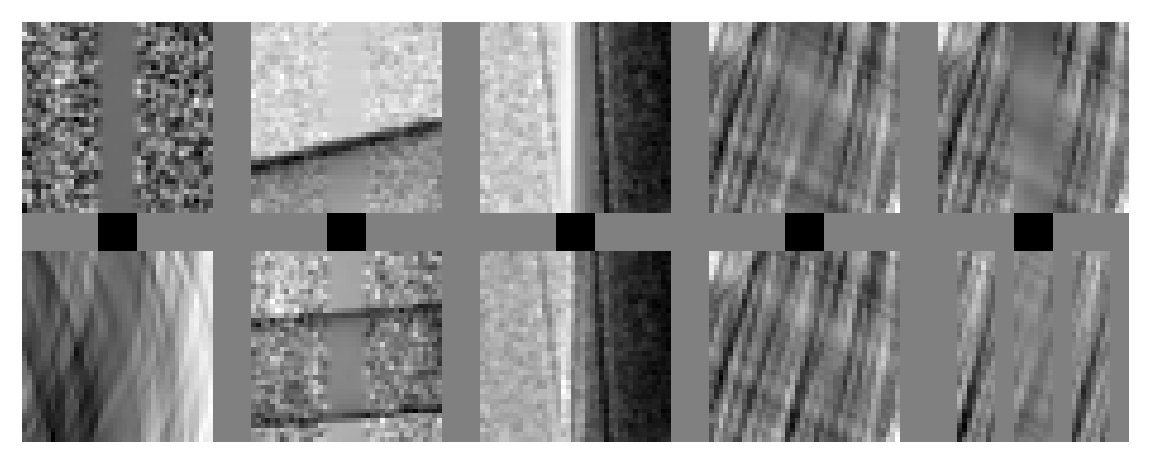

 67%|██████▋   | 2280/3424 [36:57<18:30,  1.03it/s]

In [ ]:

#for item in itertools.chain( sg.optimizer_D.param_groups, sg.optimizer_G.param_groups ):
#    item['lr'] *= 0.1
sg.TCfg.batchSize = 1509
sg.dataLoader = sg.createTrainLoader(trainSet)#, num_workers=0)
sg.testLoader = sg.createTestLoader(testSet)#, num_workers=0)
#Rec_diff, MSE_diff, L1L_diff = sg.summarizeSet(sg.testLoader)
##Summary. Rec: 1.029e-03, MSE: 1.029e-03, L1L: 1.262e-02.
#sg.writer.add_scalars("Test per epoch",
#                   {'MSE': MSE_diff
#                   ,'L1L': L1L_diff
#                   ,'REC': Rec_diff
#                   }, 0 )
#Rec_diff, MSE_diff, L1L_diff = sg.summarizeSet(sg.testLoader, False)
##Summary. Rec: 9.778e-04, MSE: 9.778e-04, L1L: 1.254e-02.
#sg.writer.add_scalars("Test per epoch",
#                   {'MSE': MSE_diff
#                   ,'L1L': L1L_diff
#                   ,'REC': Rec_diff
#                   }, sg.epoch )


#torch.autograd.set_detect_anomaly(True)
#Summary. Rec: 5.178e-04, MSE: 5.178e-04, L1L: 1.345e-02.
sg.prepGdLoss =  5.178e-04
if sg.prepGdLoss == 0:
    Rec_diff, MSE_diff, L1L_diff, _, _ = sg.summarizeSet(sg.dataLoader)
    sg.prepGdLoss = Rec_diff
    sg.writer.add_scalars("Distances per epoch",
                          {'MSE0': MSE_diff
                          ,'L1L0': L1L_diff
                          ,'REC0': Rec_diff
                          }, 0 )


minGdLossToKeep = sg.minGdLoss
startingEpoch=sg.epoch
def my_afterEachEpoch(epoch) :
    global startingEpoch, minGdLossToKeep
    if epoch < startingEpoch + 2 :
        sg.minGdLoss = minGdLossToKeep
        return
    if epoch % 2 or sg.TCfg.batchSize >= 3072: # iterations: 1698
        return
    sg.TCfg.batchSize += round( 0.01 * sg.TCfg.batchSize )
    if sg.TCfg.batchSize > 3072 :
        sg.TCfg.batchSize = 3072
    del sg.dataLoader
    sg.dataLoader = sg.createTrainLoader(trainSet, num_workers=8)
    print(f"Batch size: {sg.TCfg.batchSize}")
#    for item in itertools.chain( sg.optimizer_D.param_groups, sg.optimizer_G.param_groups ):
#        item['lr'] *= 0.99
sg.afterEachEpoch = my_afterEachEpoch



sg.noAdv = True

try :
    sg.train(savedCheckPoint)
except :
    del sg.dataLoader
    del sg.testLoader
    sg.freeGPUmem()
    1/10 # to release Jupyuter memory in the next step
    raise


 # add, arch12

## <font style="color:lightblue">Post</font>

In [ ]:
sg.initialTest()


In [ ]:
sg.testMe(trainSet, 5)

### <font style="color:lightblue">Save results</font>

In [ ]:
sg.saveModels()